In [1]:
import os,sys
import numpy as np
import sympy as sym
import sys
sym.init_printing()
sys.path.append(os.path.join(os.path.pardir, 'python'))
from tcg_slb.phasediagram.scipy import ScipyPDReactiveODE
from tcg_slb.phasediagram.base import PDReactiveGrid, PDReactiveGridDiagnostics
from tcg_slb.base import *
import pickle
from pathlib import Path

reference= 'eclogitization'

In [19]:
def get_reaction(lib=''):
    pv = repr(sys.version_info.major)+'.'+repr(sys.version_info.minor)
    sys.path.append(os.path.join(os.path.pardir, 'database', 'install', lib, 'lib', 'python'+pv, 'site-packages/')) # the final slash is necessary!
    tcgdb = __import__('py_'+lib)
    func = getattr(tcgdb,lib) 
    rxn = func() # <-- this should work!
    return rxn

def get_pickle_path(rxnObj): 
    return Path('output', rxnObj.name() + '.pickle')

def load_grid(reactionObject):
    filename = get_pickle_path(reactionObject)
    with open(filename, 'rb') as pfile:
        bdfgrid = pickle.load(pfile)
    return bdfgrid

def save_grid(bdfgrid, reactionObject):
    filename = get_pickle_path(reactionObject)
    filename.parent.mkdir(exist_ok=True, parents=True)
    with open(filename, 'wb+') as pfile:
        pickle.dump(bdfgrid, pfile)

def solve_reaction_grid(reactionObject, mi0=None, Cik0=None, T_range=None, p_range=None, filename=None, reload=False, save=False, odeClass=ScipyPDReactiveODE,Da=None):
    if reload:
        return load_grid(reactionObject)

    i0 = 2 # doesn't matter as long as you pass cik0
    end = 1e5 # end time

    bdfgrid = PDReactiveGrid()

    bdfgrid.solve(reactionObject, ScipyPDReactiveODE, i0, ['T', 'p'], T_range, p_range, end, Cik0=Cik0, mi0=mi0)

    if save:
        save_grid(bdfgrid, reactionObject)

    return bdfgrid

def plot_reaction_grid(rxn, bdfgrid, plot_phases=True,figure_background=None, figure_xlim=[273.15,1273.15], figure_ylim=[0.0,5.0]):
    import matplotlib.pyplot as plt

    def decorate(pdrgd):
        def new_setup_axes(self,axi):
            if(figure_background is not None):
                img = plt.imread(figure_background)
                ip = axi.imshow(img)
            axi.axis('off')
            ax = axi.inset_axes([0.001,0.006,0.995,0.991])
            ax.patch.set_alpha(0.0)
            
            ax.set_xlabel("Temperature (K)")
            ax.set_ylabel("Pressure (GPa)")
            ax.set_xlim(figure_xlim)
            ax.set_ylim(figure_ylim)
            return ax
    
        #replace the display with newdisplay
        pdrgd.setup_axes = new_setup_axes
    
        #return the modified student 
        return pdrgd

    bdfdiag = decorate(PDReactiveGridDiagnostics)(rxn,bdfgrid) 
    s=bdfdiag.plot_rho()
    s.set_clim([25., 38.])
    s.set_cmap('jet')

    if plot_phases:
        bdfdiag.plot_phases()
    return bdfdiag

def run_reaction(rxnName=None, mi0=None, Cik0=None, t_range=None, p_range=None, reload=False, save=False,t0=900,p0=2.0,**kwargs):

    rxn = get_reaction(rxnName)

    # initial temperature, pressure and phase volume fraction
    Ti = t0 # kelvin
    pi = GPa2Bar(p0) # bars

    try:
        ode = ScipyPDReactiveODE(rxn)
        end_t = 10.0
        ode.solve(Ti,pi,mi0,Cik0,end_t,**kwargs)
        display(ode.stime)
        display(ode.final_phases(1.e-2))
        ode.plot()
    except:
        pass

    grid = solve_reaction_grid(rxn, mi0=mi0, Cik0=Cik0, T_range=t_range, p_range=p_range, reload=reload, save=save,**kwargs)
    plot_reaction_grid(rxn,grid, plot_phases=True)
    return rxn, grid

In [20]:
Tmin = 273
Tmax = 1273
nT = 30

Pmin = 0.
Pmax = 2.5
nP = 30

T = np.linspace(Tmin, Tmax, nT)
P = np.linspace(Pmin, Pmax, nP)

phases = [
    'Clinopyroxene',
    'Orthopyroxene',
    'Quartz',
    'Feldspar', 
    'Garnet', 
    'Kyanite',
    'Olivine',
    'Nepheline',
    'Spinel'
]

ems = [
    'Diopside', 'Hedenbergite', 'Clinoenstatite', 'CaTschermaks', 'Jadeite',
    'Enstatite', 'Ferrosilite', 'MgTschermaks', 'OrthoDiopside',
    'Quartz',
    'Anorthite','Albite',
    'Pyrope', 'Almandine', 'Grossular', 'MgMajorite', 'NaMajorite',
    'Kyanite',
    'Forsterite','Fayalite',
    'Nepheline',
    'MgSpinel','Hercynite'
]

# mass fractions of the phases

# Hacker and Abers 2003 Garnet Granulite
# except they gave it in vol%, still need to convert to wt%

## Garnet-Granulite facies
mi0 = np.asarray([
    0.185, # cpx
    0.185, # opx
    0.00, # quartz
    0.35, # feldspar
    0.28, # garnet
    0.00, # kyanite
    0.00, # olivine
    0.00, # nepheline
    0.00, # spinel
 ])

# mass fractions of the end-members
# note: * = thermodynamic endmember, set to zero
Cik0 = np.asarray([
    0.28, 0.61, 0., 0., 0.11, # di, hed, *cEn, *cats, jd
    0.5, 0.5, 0., 0., # en, fs, *mats, *oDi
    1., # quartz
    0.43, 0.57, # an, ab
    0.36, 0.46, 0.18, 0., 0., # py, alm, gr, *mgmaj, *namaj
    1., # ky
    0.5, 0.5, #fo-fa
    1., #neph
    0.5,0.5, #mgSp-hcy
])


In [16]:
rxn, grid = run_reaction(
    "eclogitization_slb_rx",
    mi0=mi0,
    Cik0=Cik0,
    t_range=T,
    p_range=P,
    t0=1200,
    p0=2.5,
    reload=False,
    save=True,
)

NameError: name 'mi0' is not defined

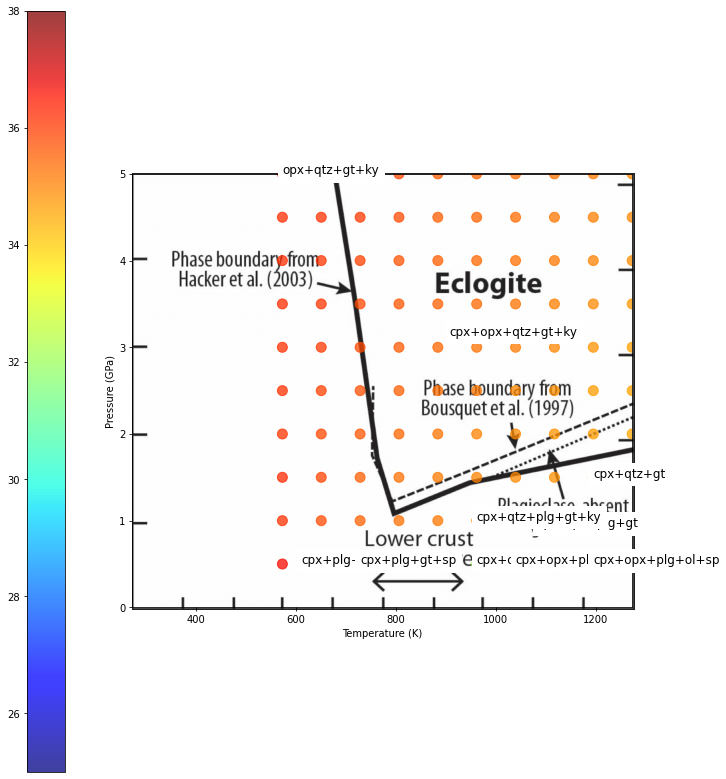

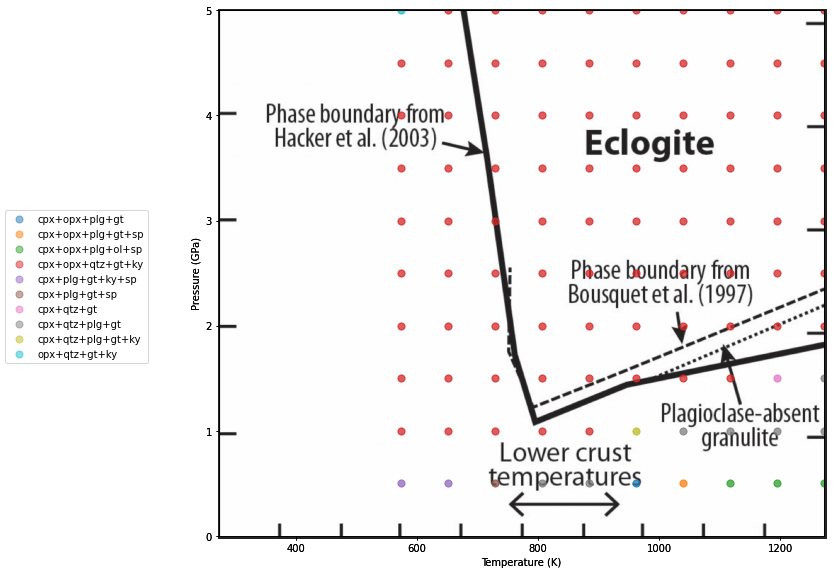

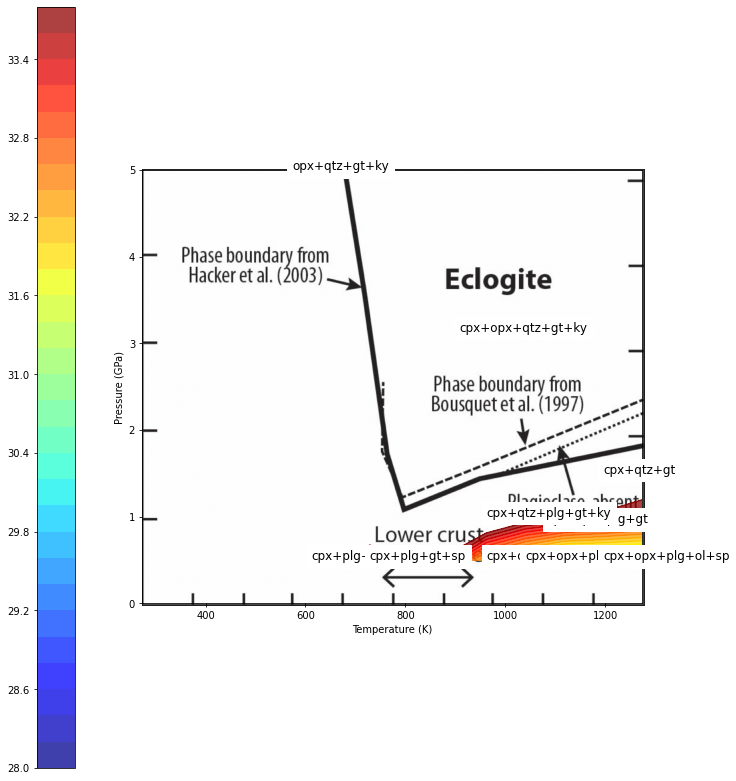

In [22]:
from matplotlib import pyplot as plt

bdfdiag = plot_reaction_grid(
    rxn, 
    grid, 
    plot_phases=True,
    figure_background="figures/krystopowicz-a4.png",
    figure_xlim = [273.,1273.],
    figure_ylim = [0., 5.,]
)

bdfdiag.plot_rho_contours()
plt.savefig('figs/mafic/density-krystopowicz.pdf')


In [ ]:
bdfdiag = plot_reaction_grid(
    rxn,
    grid,
    plot_phases=True,
    figure_background="figures/hp62-cropped.png",
    figure_xlim=[773.0, 1273.0],
    figure_ylim=[0.5, 2.5,],
)
bdfdiag.plot_rho_contours()


In [ ]:
bdfdiag.plot_phases()
plt.savefig('figs/mafic/hp62-pseudosection.pdf')

In [ ]:
bdfdiag = plot_reaction_grid(
    rxn,
    grid,
    figure_background="figures/hp62-density-cropped.png",
    figure_xlim=[773.0, 1273.0],
    figure_ylim=[0.5, 2.5,],
)

s=bdfdiag.plot_rho()
s.set_clim([25., 35.])
s.set_cmap('jet')
plt.savefig('figs/mafic/hp62-density.pdf')

In [ ]:
s=bdfdiag.plot_rho_contours()
plt.savefig('figs/mafic/hp62-density-contours.pdf')

In [ ]:
bdfdiag = plot_reaction_grid(rxn,grid)
bdfdiag.plot_stime()

In [ ]:
i0 = 2 # doesn't matter as long as you pass cik0
end = 10 # end time

bdfgrid = PDReactiveGrid()

Trange = [1000.]
Prange = np.linspace(0.25, 5.0, 60)
Dagrid = [[None for j in range(len(Trange))] for i in range(len(Prange))]
porosity = [[None for j in range(len(Trange))] for i in range(len(Prange))]

for i, p in enumerate(Prange):
    for j, t in enumerate(Trange):
        poro = (1.0 + np.tanh((p - 3.0)*3.0))/2 # 0 to 1
        Da_val = 0.0001 + ((poro)**10.)
        Dagrid[i][j] = Da_val
        porosity[i][j] = poro

Dagrid = np.asarray(Dagrid)

from matplotlib import pyplot as plt
plt.plot(Dagrid, Prange)
plt.show()

rxn = get_reaction("eclogitization_slb_rx")


bdfgrid.solve(rxn, ScipyPDReactiveODE, i0, ['T', 'p'], Trange, Prange, end, Cik0=Cik0, mi0=mi0_granulite, Da=0.0001)
bdfdiag = PDReactiveGridDiagnostics(rxn,bdfgrid)
rho2 = bdfdiag.rhogrid()

bdfgrid.solve(rxn, ScipyPDReactiveODE, i0, ['T', 'p'], Trange, Prange, end, Cik0=Cik0, mi0=mi0_granulite, Da=10.0)
bdfdiag = PDReactiveGridDiagnostics(rxn,bdfgrid)
rho3 = bdfdiag.rhogrid()

bdfgrid.solve(rxn, ScipyPDReactiveODE, i0, ['T', 'p'], Trange, Prange, end, Cik0=Cik0, mi0=mi0_granulite, Da=Dagrid)
bdfdiag = PDReactiveGridDiagnostics(rxn,bdfgrid)
rho1 = bdfdiag.rhogrid()

In [ ]:
from matplotlib import pyplot as plt
fig, ax1 = plt.subplots(figsize=(3, 6))
im = ax1.imshow(porosity, cmap="Blues", extent=(20,50,0.25/3000/9.8*1e6,5.0/3000/9.8*1e6), origin="lower", alpha=1., interpolation='bilinear', aspect='auto')
im.set_clim(0.0, 1.8)
ax1.set_ylim(0.25/3000/9.8*1e6,5/3000/9.8*1e6)
ax1.plot(rho2, bdfdiag.grid.ygrid/3000/9.8*1e6, 'k--', alpha=0.5)
ax1.plot(rho3, bdfdiag.grid.ygrid/3000/9.8*1e6, 'k:', alpha=0.5)
ax1.plot(rho1, bdfdiag.grid.ygrid/3000/9.8*1e6, 'k')
ax1.set_xlim(27,35)
ax1.set_xlabel("Density (kg/m$^3$)")
ax1.set_ylabel("Depth (km, $T=1000$ K)")

ax2 = ax1.twiny()
ax2.set_xlim(-0.1,1.1)
ax2.plot(Dagrid, bdfdiag.grid.ygrid/3000/9.8*1e6, 'b', linewidth=0.75)

blue = [0.6,0.7,0.9]
s = ax2.scatter([1],[1], marker='s', color=blue)
ax2.set_xlabel("Damköhler no.")
ax2.legend(['$Da(\\phi)$', '$\\phi(P)$'])
s.remove()
ax1.legend(['$\\rho, Da=0.0001$', '$\\rho, Da=10$','$\\rho, Da(\\phi)$'],loc="lower left")
ax2.xaxis.label.set_color('blue')
ax2.tick_params(axis='x', colors='blue')
plt.gca().invert_yaxis()
plt.savefig('figs/mafic/da-model.pdf')